In [16]:
# Import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def id_splitter(df: pd.DataFrame) -> pd.DataFrame:
    # Split the 'id' column
    parts = df["id"].str.split("_", expand=True)

    # Create new columns
    df["item_id"] = parts[0] + '_' + parts[1] + '_' + parts[2]
    df['store_id'] = parts[3] + '_' + parts[4]

    # Remove the original 'id' column
    df.drop(columns=['id'], inplace=True)
    df.head()
    return df

In [3]:
# Import all necessary csv files
calendar = pd.read_csv("data/calendar_afcs2024.csv")
calendar["date"] = pd.to_datetime(calendar["date"])
sell_prices = pd.read_csv("data/sell_prices_afcs2024.csv")
sales_train = id_splitter(pd.read_csv("data/sales_train_validation_afcs2024.csv"))
sales_test = id_splitter(pd.read_csv("data/sales_test_validation_afcs2024.csv"))
sales_test_evaluation = id_splitter(pd.read_csv("data/sales_test_evaluation_afcs_2024.csv"))
sample_submission = id_splitter(pd.read_csv("data/sample_submission_afcs2024.csv"))

In [4]:
prices_calendar = pd.merge(sell_prices, calendar, on="wm_yr_wk")
prices_calendar.head()

,store_id,item_id,wm_yr_wk,sell_price,date,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX
0,TX_3,FOODS_3_001,11101,2.28,2011-01-29,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
1,TX_3,FOODS_3_001,11101,2.28,2011-01-30,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0
2,TX_3,FOODS_3_001,11101,2.28,2011-01-31,Monday,3,1,2011,NaN,NaN,NaN,NaN,0
3,TX_3,FOODS_3_001,11101,2.28,2011-02-01,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1
4,TX_3,FOODS_3_001,11101,2.28,2011-02-02,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,0


In [5]:
# # Select a sample of unique items for plotting
# # Find a dynamic way to select items based on parameters
# sample_items = merged_data['item_id'].unique()[:5]

# plt.figure(figsize=(14, 8))
# for item in sample_items:
#     item_data = merged_data[merged_data['item_id'] == item]
#     plt.plot(item_data['date'], item_data['sell_price'], label=f'Item: {item}')

# plt.title('Sell Prices of Selected Items Over Time')
# plt.xlabel('Date')
# plt.ylabel('Sell Price')
# plt.legend(loc='upper left')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
# Step 2: Reshape sales_train_validation from wide to long format
sales_long = sales_train.melt(
    id_vars=["item_id", "store_id"],
    value_vars=[col for col in sales_train.columns if col.startswith("d_")],
    var_name="day",
    value_name="sales",
)

# Step 3: Extract day number from the `day` column and convert it to date
sales_long["day"] = sales_long["day"].str.extract(r"(\d+)").astype(int)

# Add a reference start date (assuming day 1 corresponds to 2011-01-29 as per merged_data)
start_date = pd.Timestamp("2011-01-29")
sales_long["date"] = start_date + pd.to_timedelta(sales_long["day"] - 1, unit='d')
sales_long = sales_long.sort_values(by=["item_id", "date"])

# Step 4: Merge the reshaped data with merged_data
train_data = pd.merge(
    sales_long,
    prices_calendar,
    on=["item_id", "store_id", "date"],
    how="left"
)
train_data = train_data.rename(columns={'Unnamed: 0': 'id'})

In [8]:
train_data.head()

,item_id,store_id,day,sales,date,wm_yr_wk,sell_price,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX
0,FOODS_3_001,TX_3,1,0,2011-01-29,11101.0,2.28,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0
1,FOODS_3_001,TX_3,2,2,2011-01-30,11101.0,2.28,Sunday,2.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0
2,FOODS_3_001,TX_3,3,1,2011-01-31,11101.0,2.28,Monday,3.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0
3,FOODS_3_001,TX_3,4,3,2011-02-01,11101.0,2.28,Tuesday,4.0,2.0,2011.0,NaN,NaN,NaN,NaN,1.0
4,FOODS_3_001,TX_3,5,0,2011-02-02,11101.0,2.28,Wednesday,5.0,2.0,2011.0,NaN,NaN,NaN,NaN,0.0


In [32]:
price_trend = train_data.groupby("date")["sell_price"].mean()

sales_trend = train_data.groupby("date")["sales"].sum()

event_prices = train_data[train_data["event_name_1"].notnull()].groupby("date")["sell_price"].mean()
event_prices = train_data[train_data["event_name_2"].notnull()].groupby("date")["sell_price"].mean()

item_sales = train_data.groupby("item_id")["sales"].sum().sort_values(ascending=False)

item_prices = train_data.groupby("item_id")["sell_price"].max().sort_values(ascending=False)

In [30]:
top_items = item_sales.head(10)
top_items

item_id
FOODS_3_586    150122
FOODS_3_090    114854
FOODS_3_252     86632
FOODS_3_555     77673
FOODS_3_377     73797
FOODS_3_030     47976
FOODS_3_202     41551
FOODS_3_714     40650
FOODS_3_587     40306
FOODS_3_694     35152
Name: sales, dtype: int64

In [41]:
top_prices = item_prices.head(10)
bottom_prices = item_prices.tail(10)
top_prices

item_id
FOODS_3_083    19.48
FOODS_3_298    19.48
FOODS_3_173    13.98
FOODS_3_272    13.68
FOODS_3_110    11.98
FOODS_3_396    11.48
FOODS_3_690     9.98
FOODS_3_244     9.88
FOODS_3_242     9.88
FOODS_3_571     9.44
Name: sell_price, dtype: float64

I think the average does not really say much. I think it would be more useful to look at the extremes. There quite some items with much higher prices. However the volume of small priced items is just too great compared to the expensive items

C:\Users\bylin\AppData\Local\Temp\ipykernel_495928\3310037323.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


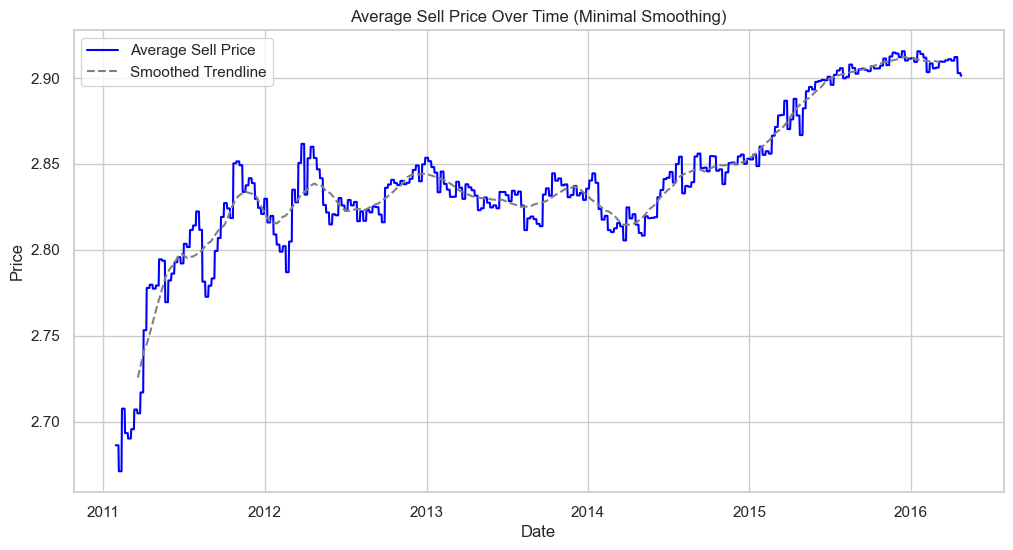

In [42]:
# Use seaborn's built-in smoothing with a low smoothing parameter (low `lowess` frac equivalent)
plt.figure(figsize=(12, 6))
sns.lineplot(
    x=price_trend.index,
    y=price_trend.values,
    label="Average Sell Price",
    ci=None,
    color="blue",
)
sns.lineplot(
    x=price_trend.index,
    y=price_trend.rolling(window=100, center=True).mean(),
    label="Smoothed Trendline",
    color="grey",
    linestyle="--",
)
plt.title("Average Sell Price Over Time (Minimal Smoothing)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

C:\Users\bylin\AppData\Local\Temp\ipykernel_495928\1348088111.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


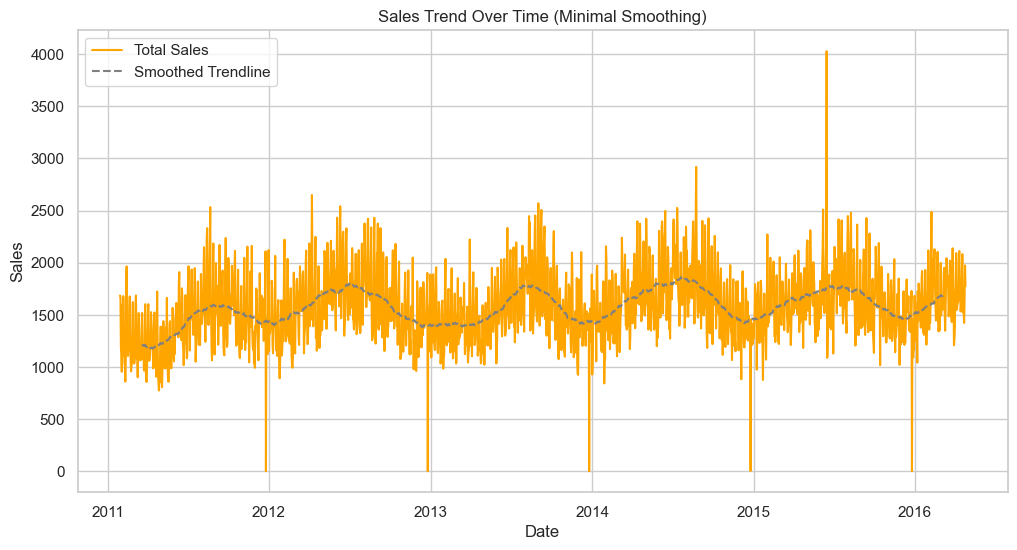

In [43]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    x=sales_trend.index,
    y=sales_trend.values,
    label="Total Sales",
    ci=None,
    color="orange",
)
sns.lineplot(
    x=sales_trend.index,
    y=sales_trend.rolling(window=100, center=True).mean(),
    label="Smoothed Trendline",
    color="grey",
    linestyle="--",
)
plt.title("Sales Trend Over Time (Minimal Smoothing)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

C:\Users\bylin\AppData\Local\Temp\ipykernel_495928\3363445687.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


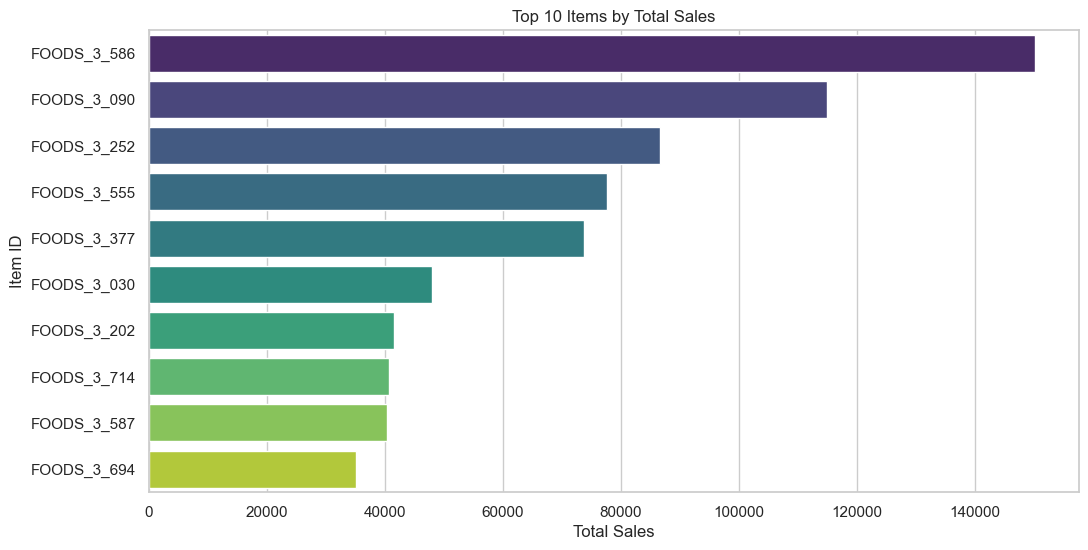

In [44]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_items.values,
    y=top_items.index,
    palette="viridis",
    orient="h",
)
plt.title("Top 10 Items by Total Sales")
plt.xlabel("Total Sales")
plt.ylabel("Item ID")
plt.show()

C:\Users\bylin\AppData\Local\Temp\ipykernel_495928\2793363860.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


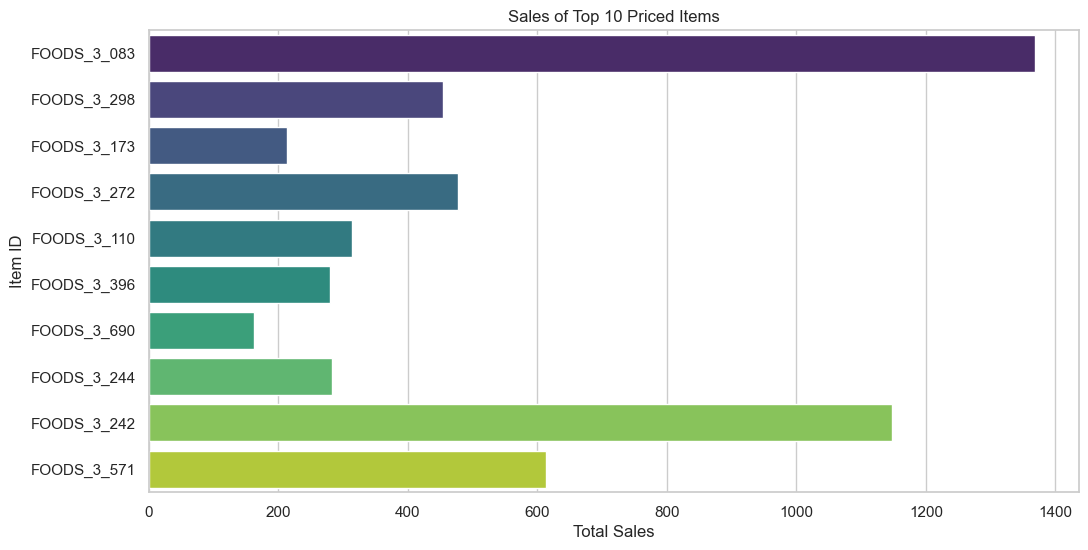

In [45]:

top_prices_ids = top_prices.index.tolist()

# Filter the sales data for the top-priced items
top_price_sales = item_sales.loc[top_prices_ids]

# Plot the sales for the top-priced items
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_price_sales.values,
    y=top_price_sales.index,
    palette="viridis",
    orient="h",
)
plt.title("Sales of Top 10 Priced Items")
plt.xlabel("Total Sales")
plt.ylabel("Item ID")
plt.show()

C:\Users\bylin\AppData\Local\Temp\ipykernel_495928\3530626626.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


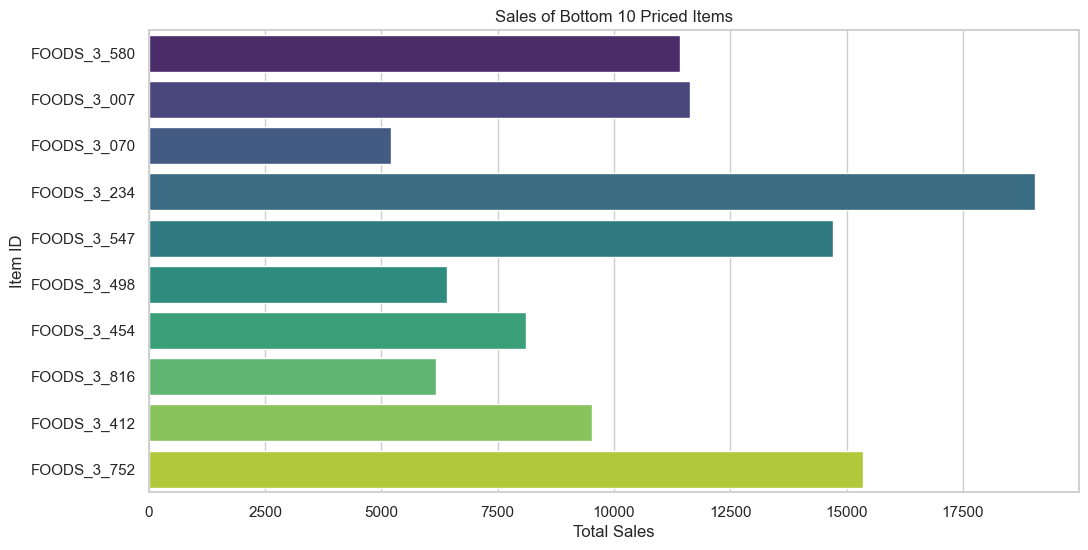

In [46]:
bottom_prices_ids = bottom_prices.index.tolist()

# Filter the sales data for the top-priced items
bottom_price_sales = item_sales.loc[bottom_prices_ids]

# Plot the sales for the top-priced items
plt.figure(figsize=(12, 6))
sns.barplot(
    x=bottom_price_sales.values,
    y=bottom_price_sales.index,
    palette="viridis",
    orient="h",
)
plt.title("Sales of Bottom 10 Priced Items")
plt.xlabel("Total Sales")
plt.ylabel("Item ID")
plt.show()